このチュートリアルを試してみます

https://pytorch-lightning.readthedocs.io/en/latest/new-project.html

In [27]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl

**Step 1: Define a LightningModule (nn.Module subclass)**

A LightningModule defines a full system (ie: a GAN, autoencoder, BERT or a simple Image Classifier).

* LightningModuleは1つのモデルではなく、複数のモデルからなるシステムを扱える2（この例でもencoderとdecoderを扱っている）
* forwardメソッドとtraining_stepメソッドを分離forwardはデプロイしたモデルの推論でも使える）
* training_stepメソッド（訓練）でlossを返している限りはLightningによって自動で最適化される（backward、optimizerの更新）

注: Training_step はトレーニングループを定義します。Forwardは、推論/予測中のLightningModuleの動作を定義します。

In [28]:
# MNIST 28*28 の手書き文字データセットを使います
class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super(LitAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )
        #ここはこういう書き方でもOK
#         self.encoder = nn.Sequential(nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 28 * 28),
        )
#         self.decoder = nn.Sequential(nn.Linear(3, 128), nn.ReLU(), nn.Linear(128, 28 * 28))
    def forward(self, x):
        # Lightningではforwardは予測/推論のアクションを定義します。
        embedding = self.encoder(x)
        return embedding

    def configure_optimizers(self):# Optimaizerの設定
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        # training_stepでは訓練ループを定義していて、これはforwardとは独立しています
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)  # forwardを呼び出す self(x) でもよい
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    # lossを返している限りはLightningによって自動で最適化される（backward、optimizerの更新）

    def validation_step(self, val_batch, batch_idx):
        # 検証ステップ
        x, y = val_batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("val_loss", loss)
        return loss

**Step2 : Train!**

GPU/TPUを使いたいとき、勝手にGPUを使う設定になります！

**Delete .cuda() or .to() calls** これらは使わない！！

なにか新しいTensorを使わないといけないときはこう！！！

こうじゃなくて
```
# before lightning
def forward(self, x):
    z = torch.Tensor(2, 3)
    z = z.cuda(0)
```
こう！！！
```
# with lightning
def forward(self, x):
    z = torch.Tensor(2, 3)
    z = z.type_as(x)
```

In [44]:
# MNIST 28*28 の手書き文字データセットを使います
# この時点でtensor形式に変換しています
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
# 訓練データと検証データに分けています
train, val = random_split(dataset, [55000, 5000])

#モデルの呼び出しと初期化
autoencoder = LitAutoEncoder()# 学習モデルのインスタンス化
#トレーニング開始
trainer = pl.Trainer(max_epochs=10, gpus=1)# 学習用のインスタンス化と学習の設定

trainer.fit(autoencoder, DataLoader(train), DataLoader(val))# 学習ループ実行
# ここでdataLoaderした訓練データと検証データをわたす。

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50 K  
1 | decoder | Sequential | 51 K  


1

GPUやTPUを複数使いたいときはpl.Trainer()の引数に`trainer = Trainer(max_epochs=1, gpus=8)`こんなかんじで渡す。GPU１つしか積んでないときにはgpus=8あたりはあんまり関係ないですね！

```
# 8 GPUs
trainer = Trainer(max_epochs=1, gpus=8)

# 256 GPUs
trainer = Trainer(max_epochs=1, gpus=8, num_nodes=32)

# TPUs
trainer = Trainer(tpu_cores=8)
```

その他引数

Trainer引数の代表的なの
```
引数名	デフォルトの値	説明
show_progress_bar	True	学習時の進捗を標準出力
max_epochs	1000	学習時の最大エポック数
min_epochs	1	学習時の最小エポック数
train_percent_check	1.0	学習データに対する確認の比率 (%)
val_percent_check	1.0	検証データに対する確認の比率 (%)
test_percent_check	1.0	テストデータに対する確認の比率 (%)
early_stop_callback	False	早期終了の使用の有無
gpus	None	使用するGPUの数
distributed_backend	None	分散学習の方法
```

**Step3 : 予測・推論**

トレーニングが完了したら、予測に使ってみよう。

予測には３つのオプションがあります。

1. システム中のモデルを引用してくる
1. Forwordメソッドを使う
1. Productionメソッドを使う（これが最速！）

**方法1：システム中のモデルを引用してくる**

lightningで学習を行うと、logの中にcheckpointが保存されるので、これをロードしてくるのが一つの方法

In [48]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

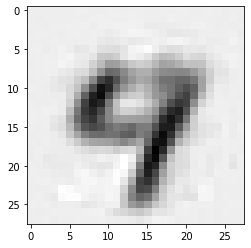

In [104]:
# ----------------------------------
# to use as embedding extractor
# ----------------------------------
autoencoder = LitAutoEncoder.load_from_checkpoint('lightning_logs/version_2/checkpoints/epoch=7.ckpt')
encoder_model = autoencoder.encoder
encoder_model.eval()# これで推論モードで使える

# ----------------------------------
# to use as image generator
# ----------------------------------
decoder_model = autoencoder.decoder
decoder_model.eval()# これで推論モードで使える

input_sample = torch.randn((1, 3))#なんか適当に入力
output = decoder_model(input_sample)
output = torch.reshape(output,(28,28))

plt.imshow(output.to('cpu').detach().numpy(),cmap="binary")#tensor->numpyして表示

**おすすめの方法：学習済みモデルを保存する**

２つ方法があって、ひとつはTorchScript(.pt形式)で保存すること

True


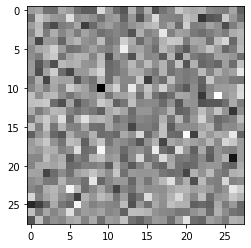

In [110]:
# ----------------------------------
# torchscript GPU ver
# ----------------------------------
autoencoder = LitAutoEncoder()
torch.save(autoencoder, "GPUmodel.pt")
print(os.path.isfile("GPUmodel.pt")) # ファイルの存在を確認する

torch.load("GPUmodel.pt")

decoder_model.eval()# これで推論モードで使える

input_sample = torch.randn((1, 3))#なんか適当に入力
output = decoder_model(input_sample)
output = torch.reshape(output,(28,28))

plt.imshow(output.to('cpu').detach().numpy(),cmap="binary")#tensor->numpyして表示

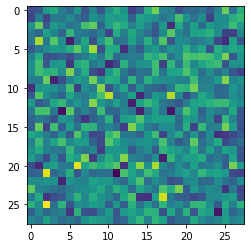

In [108]:
# ----------------------------------
# torchscript CPU ver
# ----------------------------------
autoencoder = LitAutoEncoder()
torch.jit.save(autoencoder.to('cpu').to_torchscript(), "CPUmodel.pt")#tensor->numpyしてsave
os.path.isfile("CPUmodel.pt") # ファイルの存在を確認する

# Loading
cpumodel = torch.jit.load("CPUmodel.pt")

# ----------------------------------
# to use as image generator
# ----------------------------------
decoder_model = cpumodel.decoder
decoder_model.eval()# これで推論モードで使える

input_sample = torch.randn((1, 3))#なんか適当に入力
output = decoder_model(input_sample)
output = torch.reshape(output,(28,28))

plt.imshow(output.to('cpu').detach().numpy())#tensor->numpyして表示